In [1]:
import os
import itertools
import matplotlib.pyplot as plt
import pandas as pd 
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib import tracking
from pvlib.bifacial.pvfactors import pvfactors_timeseries
from pvlib import temperature
from pvlib.pvsystem import PVSystem, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

import time
from pvlib.iotools import read_tmy3
from matplotlib import rcParams


rcParams['figure.figsize'] = 30, 10
rcParams['lines.linewidth'] = 1.5

c:\users\imardv\appdata\local\programs\python\python37\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE

In [3]:
import xgboost
from sklearn.ensemble import RandomForestRegressor

## Data

In [4]:
df = pd.read_csv('data/Merged_2020-2022_weather_data.csv', parse_dates=['DateHeure'], index_col='DateHeure')
real = df["Prod. Photovoltaique (kWh)"]

pred = pd.read_csv('data/pred_2020_2022.csv', parse_dates=['time'], index_col='time')
pred_ = pred.to_numpy()[:-1]

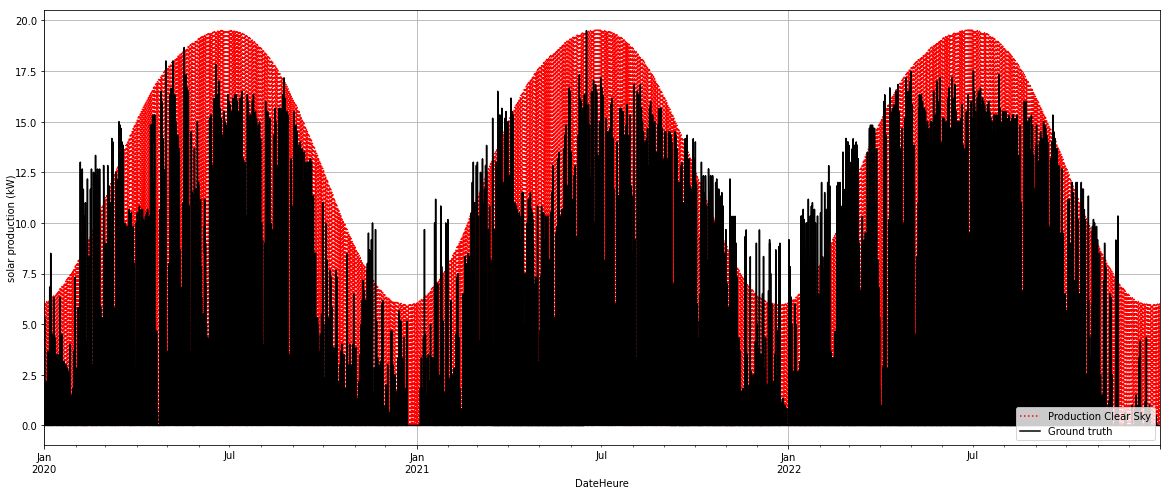

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1)
styles=['black', 'r:']

ax2 = pred.plot(ax=axes, figsize=(20,8), grid=True, style=styles[1])
ax1 = real.plot(ax=axes, figsize=(20,8), grid=True, style=styles[0])

axes.legend(["Production Clear Sky", "Ground truth"], loc='lower right');

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("solar production (kW)")
plt.savefig('figs/clearsky_real.png')

# Seq2Point

## without nebulosity

In [6]:
df = pd.read_csv('data/Merged_2020-2022_weather_data.csv', parse_dates=['DateHeure'], index_col='DateHeure')['2020':'2021']
real = df["Prod. Photovoltaique (kWh)"]

In [7]:
max_, min_ = real.max(), real.min()

In [8]:
real = (real - min_) / (max_ - min_)

In [9]:
X_seq2seq, y_seq2seq = [], []
seq_len = 24
for i in range(seq_len, len(real)):
    X_seq2seq.append(real[i-seq_len:i])
    y_seq2seq.append(real[i])

X_seq2seq = np.array(X_seq2seq)
y_seq2seq = np.array(y_seq2seq)

In [10]:
trainX_seq2seq, trainY_seq2seq = X_seq2seq[:int(len(X_seq2seq)*0.50)], y_seq2seq[:int(len(X_seq2seq)*0.50)]
testX_seq2seq, testY_seq2seq = X_seq2seq[int(len(X_seq2seq)*0.50):], y_seq2seq[int(len(X_seq2seq)*0.50):]

### LSTM

In [11]:
import keras
import tensorflow as tf

In [12]:
model2021 = keras.models.Sequential()
model2021.add(keras.layers.LSTM(128))
model2021.add(keras.layers.Dense(1, activation = 'relu'))
model2021.compile(loss= ['mse'], optimizer= 'rmsprop', metrics= tf.keras.metrics.RootMeanSquaredError())
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=5)

In [13]:
trainX_seq2seq = trainX_seq2seq.reshape((len(trainX_seq2seq), 24, 1))
testX_seq2seq = testX_seq2seq.reshape((len(testX_seq2seq), 24, 1))

In [14]:
start_time = time.time()
history = model2021.fit(trainX_seq2seq, trainY_seq2seq, epochs=100, batch_size=32,validation_split=.2, verbose=0, callbacks=my_callbacks)
print("--- %s seconds ---" % (time.time() - start_time))

--- 52.21078681945801 seconds ---


In [15]:
lstm_predict = model2021.predict(testX_seq2seq)

274/274 [==============================] - 2s 7ms/step


In [16]:
testScore = np.sqrt(MSE(lstm_predict * max_, testY_seq2seq * max_))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 2.78 RMSE


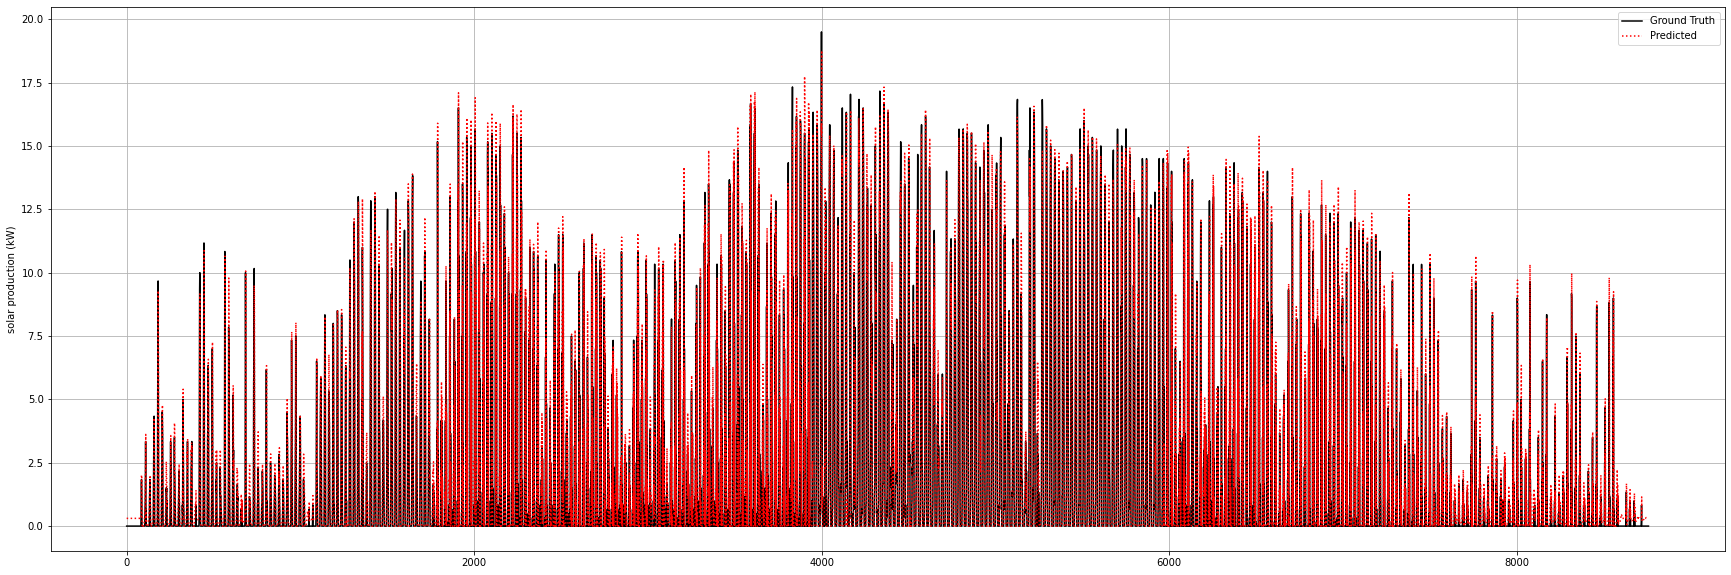

In [17]:
plt.plot(testY_seq2seq * max_, label='Ground Truth', color='black')
plt.plot(lstm_predict * max_, label='Predicted', color='red', linestyle='dotted')
plt.legend()
plt.ylabel('solar production (kW)')
plt.grid(True)
plt.savefig('figs/lstm_hist.png')

In [18]:
'''
fig, axes = plt.subplots(nrows=2, ncols=1)
styles=['b:', 'r:', 'k-']
ax5=dfJoin.plot(ax=axes[0], y=['GHI_Model1','GHI_Model2','Ray_Global_RSR2_Avg'],figsize=(5,8), grid=True, style=styles)
ax5.legend(["GHI forecast","GHI forecast +1d", "Ground truth"], loc='lower right');
styles=['b:', 'r:', 'k-']
ax6=dfJoin.plot(ax=axes[1], y=['DNI_Model1','DNI_Model2','Ray_Direct_RSR2_Avg'],figsize=(5,8), grid=True, style=styles)
ax6.legend(["DNI forecast","DNI forecast +1d", "Ground truth"], loc='lower right');
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("solar radiations (W/m$^2$)")
plt.savefig('8days_forecast.png', dpi=300)
'''

'\nfig, axes = plt.subplots(nrows=2, ncols=1)\nstyles=[\'b:\', \'r:\', \'k-\']\nax5=dfJoin.plot(ax=axes[0], y=[\'GHI_Model1\',\'GHI_Model2\',\'Ray_Global_RSR2_Avg\'],figsize=(5,8), grid=True, style=styles)\nax5.legend(["GHI forecast","GHI forecast +1d", "Ground truth"], loc=\'lower right\');\nstyles=[\'b:\', \'r:\', \'k-\']\nax6=dfJoin.plot(ax=axes[1], y=[\'DNI_Model1\',\'DNI_Model2\',\'Ray_Direct_RSR2_Avg\'],figsize=(5,8), grid=True, style=styles)\nax6.legend(["DNI forecast","DNI forecast +1d", "Ground truth"], loc=\'lower right\');\n# add a big axes, hide frame\nfig.add_subplot(111, frameon=False)\n# hide tick and tick label of the big axes\nplt.tick_params(labelcolor=\'none\', top=False, bottom=False, left=False, right=False)\nplt.grid(False)\nplt.ylabel("solar radiations (W/m$^2$)")\nplt.savefig(\'8days_forecast.png\', dpi=300)\n'

# with nebulosity

In [19]:
neb = pd.read_csv('data/full_neb_2020_2021.csv', sep=',', parse_dates=['time'], index_col='time')

In [20]:
neb_array = neb.to_numpy() / 100

In [21]:
df = pd.read_csv('data/Merged_2020-2022_weather_data.csv', parse_dates=['DateHeure'], index_col='DateHeure')['2020':'2021']
real = df["Prod. Photovoltaique (kWh)"].iloc[:-1]

In [22]:
max_, min_ = real.max(), real.min()

In [23]:
real = (real - real.min()) / (real.max() - real.min())

In [24]:
X_seq2seq, y_seq2seq = [], []
seq_len = 24
for i in range(seq_len, len(real)):
    tmp = real[i-seq_len:i].to_list()
    tmp.append(neb_array[i][0])
    X_seq2seq.append(tmp)
    y_seq2seq.append(real[i])

X_seq2seq = np.array(X_seq2seq)
y_seq2seq = np.array(y_seq2seq)

In [25]:
trainX_seq2seq, trainY_seq2seq = X_seq2seq[:int(len(X_seq2seq)*0.50)], y_seq2seq[:int(len(X_seq2seq)*0.50)]
testX_seq2seq, testY_seq2seq = X_seq2seq[int(len(X_seq2seq)*0.50):], y_seq2seq[int(len(X_seq2seq)*0.50):]

### LSTM

In [26]:
model2021 = keras.models.Sequential()
model2021.add(keras.layers.LSTM(128))
model2021.add(keras.layers.Dense(1, activation = 'relu'))
model2021.compile(loss= ['mse'], optimizer= 'rmsprop', metrics= tf.keras.metrics.RootMeanSquaredError())
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=5)

In [27]:
trainX_seq2seq = trainX_seq2seq.reshape((len(trainX_seq2seq), 25, 1))
testX_seq2seq = testX_seq2seq.reshape((len(testX_seq2seq), 25, 1))

In [28]:
start_time = time.time()
history = model2021.fit(trainX_seq2seq, trainY_seq2seq, epochs=100, batch_size=32,validation_split=.2, verbose=0, callbacks=my_callbacks)
print("--- %s seconds ---" % (time.time() - start_time))

--- 97.78982639312744 seconds ---


In [29]:
lstm_predict = model2021.predict(testX_seq2seq)

274/274 [==============================] - 2s 7ms/step


In [30]:
testScore = np.sqrt(MSE(lstm_predict * max_, testY_seq2seq * max_))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 2.83 RMSE


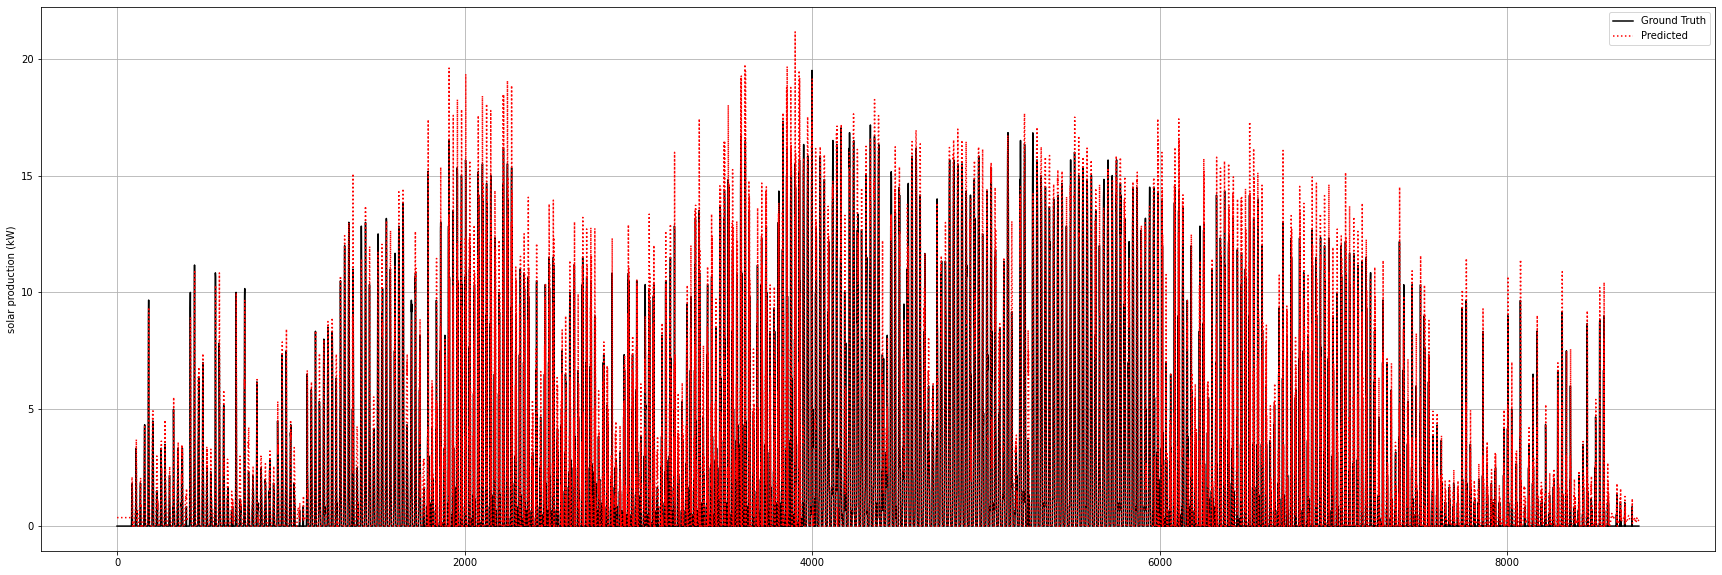

In [31]:
plt.plot(testY_seq2seq * max_, label='Ground Truth', color='black')
plt.plot(lstm_predict * max_, label='Predicted', color='red', linestyle='dotted')
plt.legend()
plt.ylabel('solar production (kW)')
plt.grid(True)
plt.savefig('figs/lstm_hist_neb.png')

# Fit on error

## Without neb

In [58]:
pred = pd.read_csv('data/pred_2020_2022.csv', parse_dates=['time'], index_col='time')[:'2021']
pred_ = pred.to_numpy()[:-1]

In [59]:
df = pd.read_csv('data/Merged_2020-2022_weather_data.csv', parse_dates=['DateHeure'], index_col='DateHeure')[:'2021']
real = df["Prod. Photovoltaique (kWh)"][:-1]

In [60]:
error = pred_.flatten() - real.to_numpy()

In [61]:
max_, min_ = error.max(), error.min()

In [62]:
error = (error - error.min())/(error.max() - error.min())

In [63]:
seq_len = 24
X_test, y_test = [], []
for i in range(seq_len, len(error)):
    tmp = [error[i-seq_len:i].tolist()]
    X_test.append(tmp)
    y_test.append(error[i])

X_test = np.array(X_test)
y_test = np.array(y_test)

trainX_test, trainY_test = X_test[:int(len(X_test)*0.50)], y_test[:int(len(X_test)*0.50)]
testX_test, testY_test = X_test[int(len(X_test)*0.50):], y_test[int(len(X_test)*0.50):]

In [64]:
trainX_test = trainX_test.reshape((len(trainX_test), 24))
testX_test = testX_test.reshape((len(testX_test), 24))

## LSTM

In [65]:
model2021 = keras.models.Sequential()
model2021.add(keras.layers.LSTM(128))
model2021.add(keras.layers.Dense(1, activation = 'relu'))
model2021.compile(loss= ['mse'], optimizer= 'rmsprop', metrics= tf.keras.metrics.RootMeanSquaredError())
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=5)

In [66]:
trainX_test = trainX_test.reshape((len(trainX_test), 24, 1))
testX_test = testX_test.reshape((len(testX_test), 24, 1))

In [67]:
start_time = time.time()
history = model2021.fit(trainX_test, trainY_test, epochs=100, batch_size=32,validation_split=.2, verbose=0, callbacks=my_callbacks)
print("--- %s seconds ---" % (time.time() - start_time))

--- 84.58818697929382 seconds ---


In [68]:
lstm_predict = (model2021.predict(testX_test).flatten() * (max_ - min_)) + min_

274/274 [==============================] - 2s 7ms/step


In [69]:
lstm_predict = (pred_[int(len(X_test)*0.50):].flatten()[24:] - lstm_predict)

In [70]:
lstm_predict = np.array([data if data >= 0 else 0 for data in lstm_predict])

In [71]:
testScore = np.sqrt(MSE(lstm_predict, real[int(len(X_test)*0.50):][24:].to_numpy()))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 2.76 RMSE


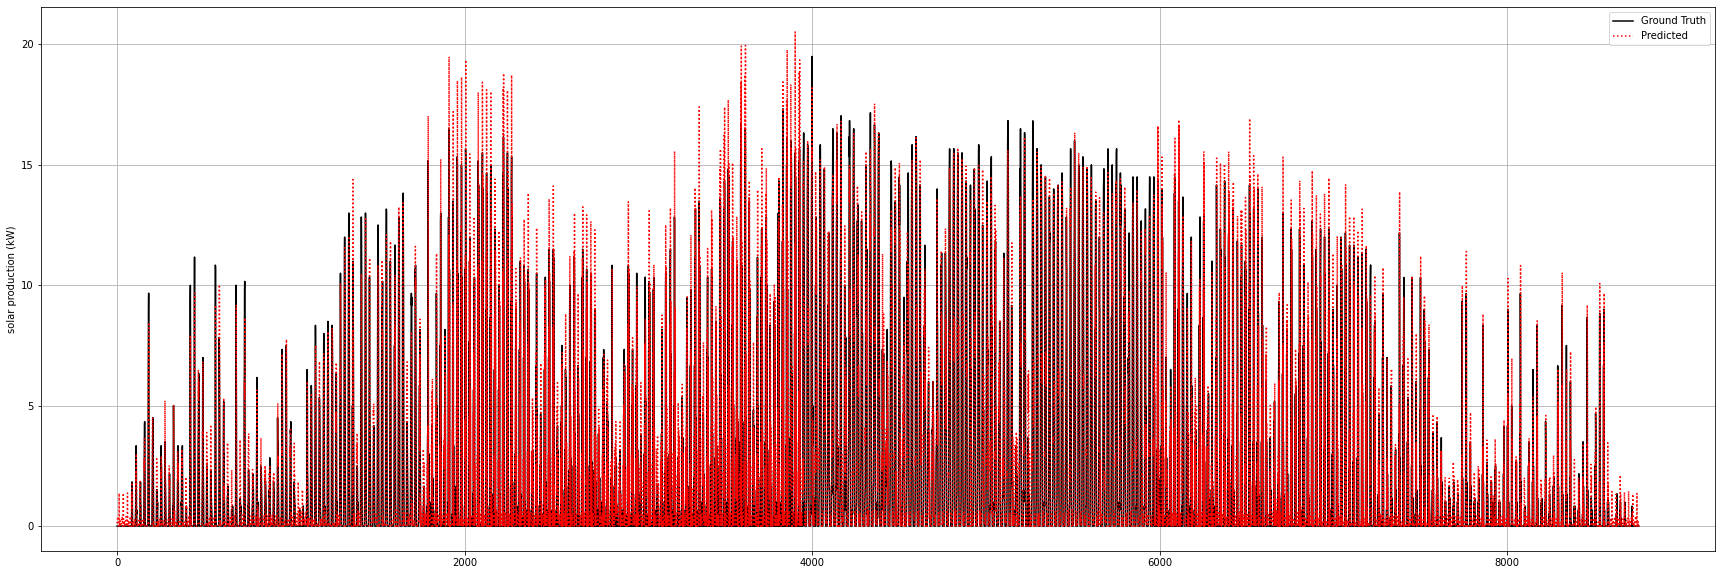

In [72]:
plt.plot(real[int(len(X_test)*0.50):][24:].to_numpy(),  label='Ground Truth', color='black')
plt.plot(lstm_predict,  label='Predicted', color='red', linestyle='dotted')
plt.legend()
plt.ylabel('solar production (kW)')
plt.grid(True)
plt.savefig('figs/lstm_error_hist.png')

# with neb

## LSTM

In [95]:
pred = pd.read_csv('data/pred_2020_2022.csv', parse_dates=['time'], index_col='time')[:'2021']
pred_ = pred.to_numpy()[:-1]

neb = pd.read_csv('data/full_neb_2020_2021.csv', sep=',', parse_dates=['time'], index_col='time')
neb_array = neb.to_numpy()/100

df = pd.read_csv('data/Merged_2020-2022_weather_data.csv', parse_dates=['DateHeure'], index_col='DateHeure')['2020':'2021']
real = df["Prod. Photovoltaique (kWh)"].iloc[:-1]

error = pred_.flatten() - real.to_numpy()

max_, min_ = error.max(), error.min()
error = (error - error.min()) / (error.max() - error.min())

In [96]:
X_seq2seq, y_seq2seq = [], []
seq_len = 24
for i in range(seq_len, len(real)):
    tmp = error[i-seq_len:i].tolist()
    tmp.append(neb_array[i][0])
    X_seq2seq.append(tmp)
    y_seq2seq.append(error[i])

X_seq2seq = np.array(X_seq2seq)
y_seq2seq = np.array(y_seq2seq)

In [97]:
trainX_seq2seq, trainY_seq2seq = X_seq2seq[:int(len(X_seq2seq)*0.50)], y_seq2seq[:int(len(X_seq2seq)*0.50)]
testX_seq2seq, testY_seq2seq = X_seq2seq[int(len(X_seq2seq)*0.50):], y_seq2seq[int(len(X_seq2seq)*0.50):]

In [98]:
model2021 = keras.models.Sequential()
model2021.add(keras.layers.LSTM(128))
model2021.add(keras.layers.Dense(1, activation = 'relu'))
model2021.compile(loss= ['mse'], optimizer= 'rmsprop', metrics= tf.keras.metrics.RootMeanSquaredError())
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=5)

In [99]:
trainX_seq2seq = trainX_seq2seq.reshape((len(trainX_seq2seq), 25, 1))
testX_seq2seq = testX_seq2seq.reshape((len(testX_seq2seq), 25, 1))

In [100]:
start_time = time.time()
history = model2021.fit(trainX_seq2seq, trainY_seq2seq, epochs=100, batch_size=32, validation_split=.2, verbose=0, callbacks=my_callbacks)
print("--- %s seconds ---" % (time.time() - start_time))

--- 79.8874180316925 seconds ---


In [101]:
lstm_predict = (model2021.predict(testX_seq2seq).flatten() * (max_ - min_)) + min_

274/274 [==============================] - 3s 10ms/step


In [102]:
lstm_predict = pred_[int(len(X_test)*0.50):].flatten()[24:] - lstm_predict

In [103]:
lstm_predict = np.array([data if data >= 0 else 0 for data in lstm_predict])

In [104]:
testScore = np.sqrt(MSE(lstm_predict, real[int(len(X_test)*0.50):][24:].to_numpy()))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 2.76 RMSE


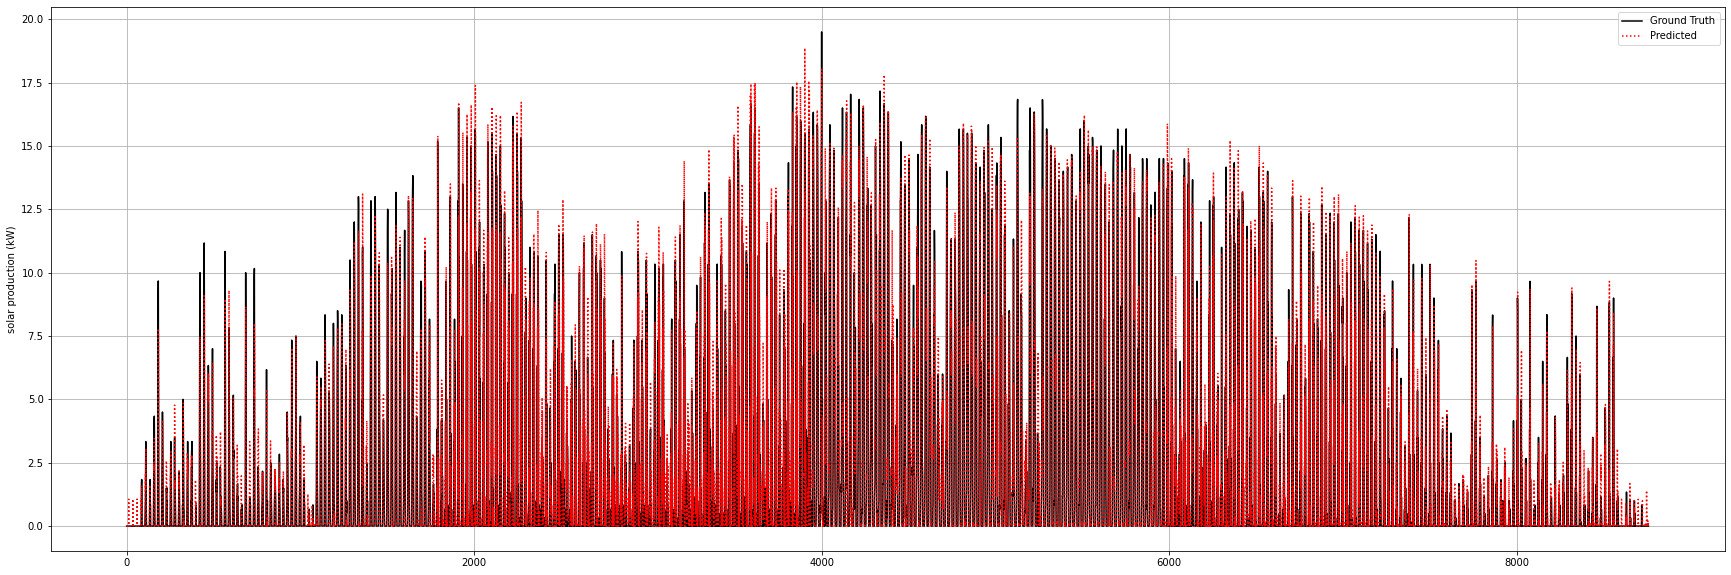

In [105]:
plt.plot(real[int(len(X_test)*0.50):][24:].to_numpy(),  label='Ground Truth', color='black')
plt.plot(lstm_predict,  label='Predicted', color='red', linestyle='dotted')
plt.legend()
plt.ylabel('solar production (kW)')
plt.grid(True)
plt.savefig('figs/lstm_error_hist_neb.png')